Clearly state the goal of your project (what were you exploring? what scientific question did you ask?)
Describe the data.

What features (columns) did you have to work with? What features were you interested in?

Were the features numerical/categorical/text?

Was a lot of data missing or other problems? If so, what did you do to handle it?

How did features relate to each other, and the values that you were interested in?

Pictures are worth 1000s of words!

Clearly state the steps you took to build your model.

You should assume that your audience is new business owners seeking a loan and trying make decisions about what loan will give them the best rate when creating this presentation.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
bank_data = pd.read_csv('/Users/cdmoseley/dai_files/assignments/Week_8/interest_rate/Data/bank_data.csv')
bank_data.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length
0,8.90,735-739,20000.0,20000.0,36.0
1,12.12,715-719,19200.0,19200.0,36.0
2,21.98,690-694,35000.0,35000.0,60.0
3,9.99,695-699,10000.0,9975.0,36.0
4,11.71,695-699,12000.0,12000.0,36.0


In [26]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interest_rate               2498 non-null   float64
 1   fico_range                  2498 non-null   object 
 2   amount_requested            2498 non-null   float64
 3   amount_funded_by_investors  2498 non-null   float64
 4   loan_length                 2498 non-null   float64
dtypes: float64(4), object(1)
memory usage: 97.7+ KB


In [27]:
bank_data.describe()

,interest_rate,amount_requested,amount_funded_by_investors,loan_length
count,2498.000000,2498.000000,2498.000000,2498.000000
mean,13.070368,12413.030424,12009.280661,41.265012
std,4.178007,7801.222483,7743.387861,9.933753
min,5.420000,1000.000000,-0.010000,36.000000
25%,10.160000,6000.000000,6000.000000,36.000000
50%,13.110000,10000.000000,10000.000000,36.000000
75%,15.800000,17000.000000,16000.000000,36.000000
max,24.890000,35000.000000,35000.000000,60.000000


In [28]:
# bank_data['fico_range'] = bank_data['fico_range'].str.split('-')


In [29]:
bank_data['fico_low'] = bank_data['fico_range'].str[:3].astype(float)
bank_data['fico_high'] = bank_data['fico_range'].str[4:].astype(float)

In [30]:
def calculate_mean(cell):
    numbers = [int(num) for num in cell.split('-')]
    return sum(numbers) / len(numbers)
# Apply the function to each cell in the column
bank_data['fico_mean'] = bank_data['fico_range'].apply(calculate_mean)

In [31]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interest_rate               2498 non-null   float64
 1   fico_range                  2498 non-null   object 
 2   amount_requested            2498 non-null   float64
 3   amount_funded_by_investors  2498 non-null   float64
 4   loan_length                 2498 non-null   float64
 5   fico_low                    2498 non-null   float64
 6   fico_high                   2498 non-null   float64
 7   fico_mean                   2498 non-null   float64
dtypes: float64(7), object(1)
memory usage: 156.3+ KB


In [32]:
bank_data.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_low,fico_high,fico_mean
0,8.90,735-739,20000.0,20000.0,36.0,735.0,739.0,737.0
1,12.12,715-719,19200.0,19200.0,36.0,715.0,719.0,717.0
2,21.98,690-694,35000.0,35000.0,60.0,690.0,694.0,692.0
3,9.99,695-699,10000.0,9975.0,36.0,695.0,699.0,697.0
4,11.71,695-699,12000.0,12000.0,36.0,695.0,699.0,697.0


In [33]:
bank_data['Loan_Years'] = bank_data['loan_length'] / 12
def calculate_loan_repayment(principal, annual_interest_rate, loan_term_years):
    # Convert annual interest rate to monthly interest rate
    monthly_interest_rate = annual_interest_rate / 12 / 100
    # Convert loan term from years to months
    loan_term_months = loan_term_years * 12
    # Calculate monthly payment using the formula for fixed-rate mortgage
    monthly_payment = principal * (monthly_interest_rate * (1 + monthly_interest_rate)**loan_term_months) / \
                      ((1 + monthly_interest_rate)**loan_term_months - 1)
    # Calculate total amount repaid
    total_repayment = monthly_payment * loan_term_months
    # Calculate total interest earned by the bank
    total_interest_earned = total_repayment - principal
    return monthly_payment, total_repayment, total_interest_earned
# Initialize empty lists for storing calculated values
monthly_payments = []
total_repayments = []
total_interests = []
# Iterate through each row and calculate loan repayment values
for index, row in bank_data.iterrows():
    monthly_payment, total_repayment, total_interest_earned = \
        calculate_loan_repayment(row['amount_funded_by_investors'], row['interest_rate'], row['Loan_Years'])
    # Append calculated values to respective lists
    monthly_payments.append(monthly_payment)
    total_repayments.append(total_repayment)
    total_interests.append(total_interest_earned)
# Add calculated values as new columns to the DataFrame
bank_data['Monthly Payment'] = monthly_payments
bank_data['Total Repayment'] = total_repayments
bank_data['Total Interest Earned'] = total_interests
bank_data.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_low,fico_high,fico_mean,Loan_Years,Monthly Payment,Total Repayment,Total Interest Earned
0,8.90,735-739,20000.0,20000.0,36.0,735.0,739.0,737.0,3.0,635.064236,22862.312509,2862.312509
1,12.12,715-719,19200.0,19200.0,36.0,715.0,719.0,717.0,3.0,638.815744,22997.366782,3797.366782
2,21.98,690-694,35000.0,35000.0,60.0,690.0,694.0,692.0,5.0,966.263966,57975.837969,22975.837969
3,9.99,695-699,10000.0,9975.0,36.0,695.0,699.0,697.0,3.0,321.818362,11585.461041,1610.461041
4,11.71,695-699,12000.0,12000.0,36.0,695.0,699.0,697.0,3.0,396.911645,14288.819228,2288.819228


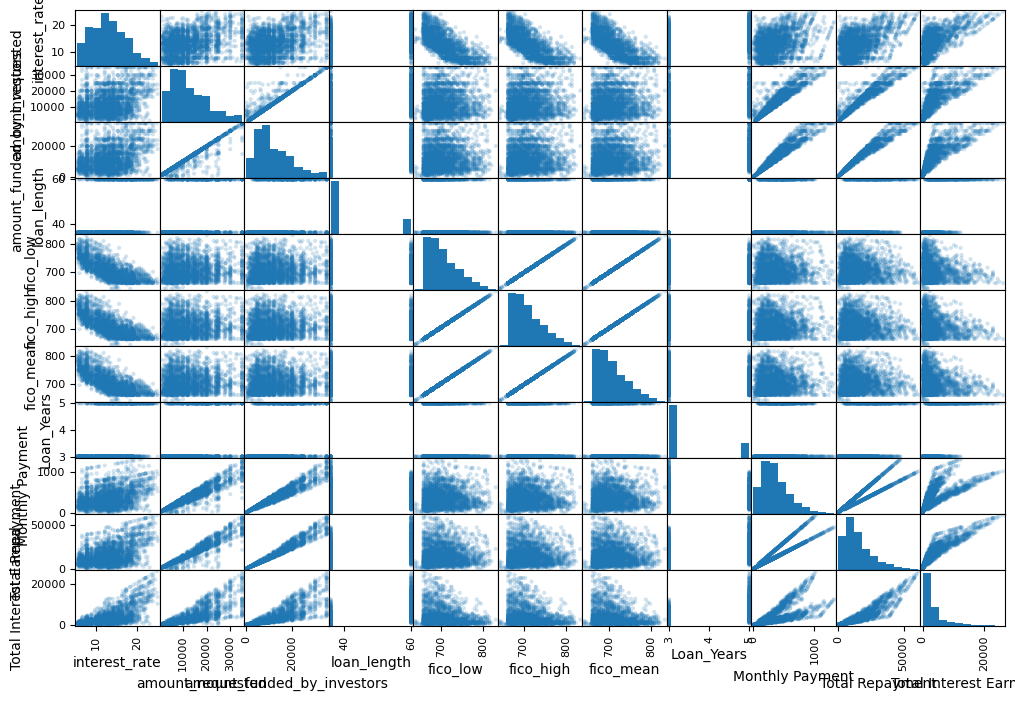

In [34]:
pd.plotting.scatter_matrix(bank_data, alpha=0.2, figsize=(12,8))
plt.show()

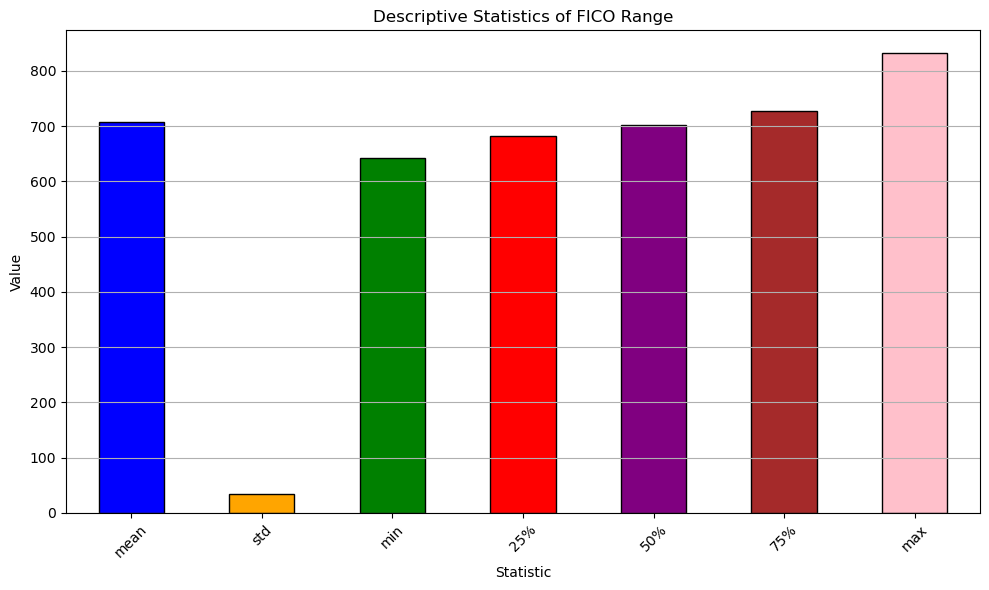

In [35]:
stats = bank_data['fico_mean'].describe().drop('count')
# Plot the descriptive statistics
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
plt.figure(figsize=(10, 6))
stats.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Descriptive Statistics of FICO Range')
plt.ylabel('Value')
plt.xlabel('Statistic')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [36]:
bank_data.head(1)

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_low,fico_high,fico_mean,Loan_Years,Monthly Payment,Total Repayment,Total Interest Earned
0,8.9,735-739,20000.0,20000.0,36.0,735.0,739.0,737.0,3.0,635.064236,22862.312509,2862.312509


In [37]:
interest_rate = bank_data
interest_rate_drop = interest_rate.drop(['interest_rate', 'fico_range', 'fico_low', 'fico_high'], axis = 1)

y = interest_rate['interest_rate']
X = interest_rate_drop
print(y)
print(X)


model = LinearRegression()
model.fit(X, y)


0        8.90
1       12.12
2       21.98
3        9.99
4       11.71
        ...  
2493    16.77
2494    14.09
2495    13.99
2496    12.42
2497    13.79
Name: interest_rate, Length: 2498, dtype: float64
      amount_requested  amount_funded_by_investors  loan_length  fico_mean  \
0              20000.0                    20000.00         36.0      737.0   
1              19200.0                    19200.00         36.0      717.0   
2              35000.0                    35000.00         60.0      692.0   
3              10000.0                     9975.00         36.0      697.0   
4              12000.0                    12000.00         36.0      697.0   
...                ...                         ...          ...        ...   
2493           30000.0                    29950.00         60.0      707.0   
2494           16000.0                    16000.00         60.0      742.0   
2495           10000.0                    10000.00         36.0      682.0   
2496            

LinearRegression()

In [38]:
X

,amount_requested,amount_funded_by_investors,loan_length,fico_mean,Loan_Years,Monthly Payment,Total Repayment,Total Interest Earned
0,20000.0,20000.00,36.0,737.0,3.0,635.064236,22862.312509,2862.312509
1,19200.0,19200.00,36.0,717.0,3.0,638.815744,22997.366782,3797.366782
2,35000.0,35000.00,60.0,692.0,5.0,966.263966,57975.837969,22975.837969
3,10000.0,9975.00,36.0,697.0,3.0,321.818362,11585.461041,1610.461041
4,12000.0,12000.00,36.0,697.0,3.0,396.911645,14288.819228,2288.819228
...,...,...,...,...,...,...,...,...
2493,30000.0,29950.00,60.0,707.0,5.0,740.635752,44438.145121,14488.145121
2494,16000.0,16000.00,60.0,742.0,5.0,373.038984,22382.339066,6382.339066
2495,10000.0,10000.00,36.0,682.0,3.0,341.727731,12302.198299,2302.198299
2496,6000.0,6000.00,36.0,677.0,3.0,200.491603,7217.697692,1217.697692


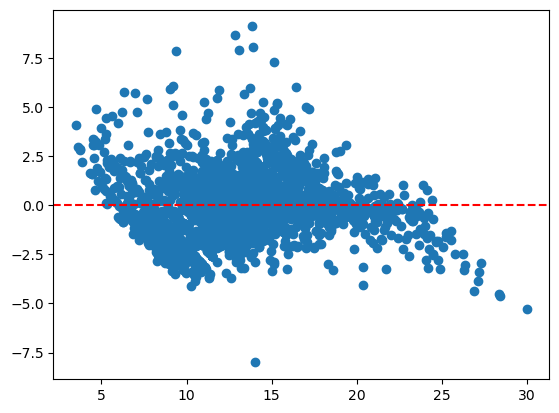

In [39]:
interest_rate_preds = model.predict(X)
resids = y - interest_rate_preds
plt.scatter(interest_rate_preds, resids)
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

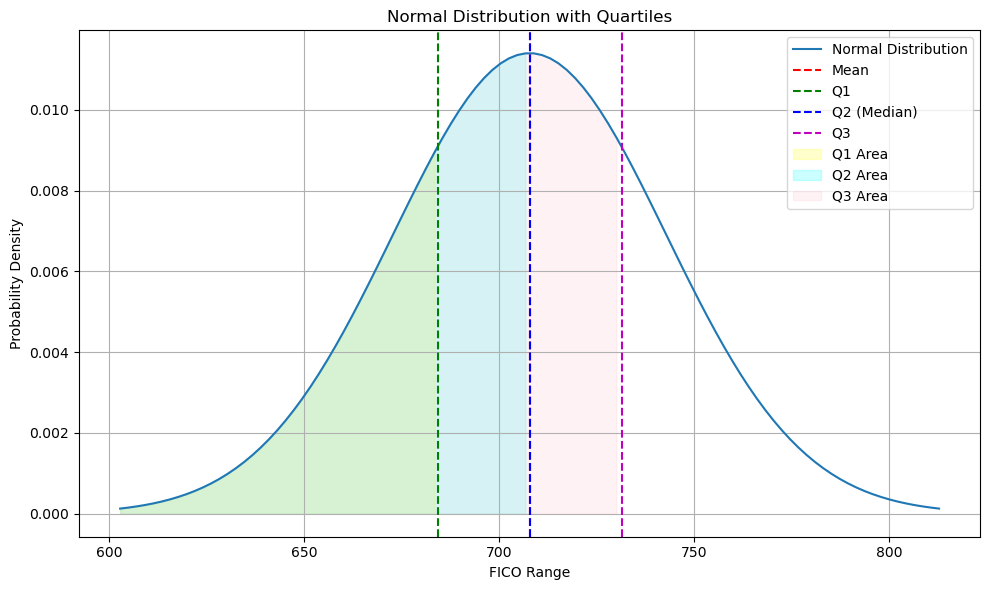

In [40]:
mean = bank_data['fico_mean'].mean()
std_dev = bank_data['fico_mean'].std()
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y = norm.pdf(x, mean, std_dev)
# Calculate quartiles
q1 = norm.ppf(0.25, mean, std_dev)
q2 = norm.ppf(0.5, mean, std_dev)
q3 = norm.ppf(0.75, mean, std_dev)
# Plot the normal distribution and quartiles
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
plt.axvline(x=mean, color='r', linestyle='--', label='Mean')
plt.axvline(x=q1, color='g', linestyle='--', label='Q1')
plt.axvline(x=q2, color='b', linestyle='--', label='Q2 (Median)')
plt.axvline(x=q3, color='m', linestyle='--', label='Q3')
plt.fill_between(x, y, where=(x <= q1), alpha=0.2, color='yellow', label='Q1 Area')
plt.fill_between(x, y, where=(x <= q2), alpha=0.2, color='cyan', label='Q2 Area')
plt.fill_between(x, y, where=(x <= q3), alpha=0.2, color='pink', label='Q3 Area')
plt.title('Normal Distribution with Quartiles')
plt.xlabel('FICO Range')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
y

array([0.00012665, 0.00015162, 0.00018085, 0.00021493, 0.0002545 ,
       0.00030024, 0.0003529 , 0.00041328, 0.00048222, 0.00056059,
       0.00064932, 0.00074932, 0.00086156, 0.00098698, 0.00112652,
       0.00128106, 0.00145147, 0.00163851, 0.00184287, 0.00206513,
       0.0023057 , 0.00256486, 0.00284269, 0.00313906, 0.00345362,
       0.00378578, 0.00413466, 0.00449914, 0.0048778 , 0.00526894,
       0.00567058, 0.00608046, 0.00649606, 0.00691463, 0.00733317,
       0.00774854, 0.00815742, 0.00855639, 0.00894197, 0.00931066,
       0.009659  , 0.00998365, 0.01028137, 0.01054915, 0.01078421,
       0.0109841 , 0.01114668, 0.01127018, 0.01135328, 0.01139506,
       0.01139506, 0.01135328, 0.01127018, 0.01114668, 0.0109841 ,
       0.01078421, 0.01054915, 0.01028137, 0.00998365, 0.009659  ,
       0.00931066, 0.00894197, 0.00855639, 0.00815742, 0.00774854,
       0.00733317, 0.00691463, 0.00649606, 0.00608046, 0.00567058,
       0.00526894, 0.0048778 , 0.00449914, 0.00413466, 0.00378

In [42]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize lists to store R2 for each fold
r2_scores = []
# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X1[train_index], X1[test_index]  # Split features
    y_train, y_test = y1[train_index], y1[test_index]  # Split target variable
    # Initialize and fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    # Calculate R2 for this fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
# Calculate average R2 across all folds
avg_r2 = np.mean(r2_scores)
print("Average R2:", avg_r2)

NameError: name 'X1' is not defined

In [ ]:
interest_rate_preds = model.predict(X)
resids = y - interest_rate_preds

plt.scatter(interest_rate_preds, resids)
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

c:\Users\shric\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 4 features, but LinearRegression is expecting 1 features as input.

In [ ]:
bank_data['Principal_Cash_Flow'] = round(bank_data['amount_funded_by_investors'] / bank_data['loan_length'], 2)
bank_data['Effective_Annual_Rate'] = round((bank_data['interest_rate'] / bank_data['loan_length']), 4)
bank_data['Interest_Cash_Flow'] = round((bank_data['Effective_Annual_Rate'] * bank_data['Principal_Cash_Flow']), 2)
bank_data['Monthly_Payment'] = bank_data['Principal_Cash_Flow'] + bank_data['Interest_Cash_Flow']
bank_data

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_low,fico_high,fico_mean,Principal_Cash_Flow,Effective_Annual_Rate,Interest_Cash_Flow,Total_Monthly_Cash_Flow,Monthly_Payment
0,8.90,735-739,20000.0,20000.00,36.0,735.0,739.0,737.0,555.56,0.2472,137.33,692.89,692.89
1,12.12,715-719,19200.0,19200.00,36.0,715.0,719.0,717.0,533.33,0.3367,179.57,712.90,712.90
2,21.98,690-694,35000.0,35000.00,60.0,690.0,694.0,692.0,583.33,0.3663,213.67,797.00,797.00
3,9.99,695-699,10000.0,9975.00,36.0,695.0,699.0,697.0,277.08,0.2775,76.89,353.97,353.97
4,11.71,695-699,12000.0,12000.00,36.0,695.0,699.0,697.0,333.33,0.3253,108.43,441.76,441.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,16.77,705-709,30000.0,29950.00,60.0,705.0,709.0,707.0,499.17,0.2795,139.52,638.69,638.69
2494,14.09,740-744,16000.0,16000.00,60.0,740.0,744.0,742.0,266.67,0.2348,62.61,329.28,329.28
2495,13.99,680-684,10000.0,10000.00,36.0,680.0,684.0,682.0,277.78,0.3886,107.95,385.73,385.73
2496,12.42,675-679,6000.0,6000.00,36.0,675.0,679.0,677.0,166.67,0.3450,57.50,224.17,224.17


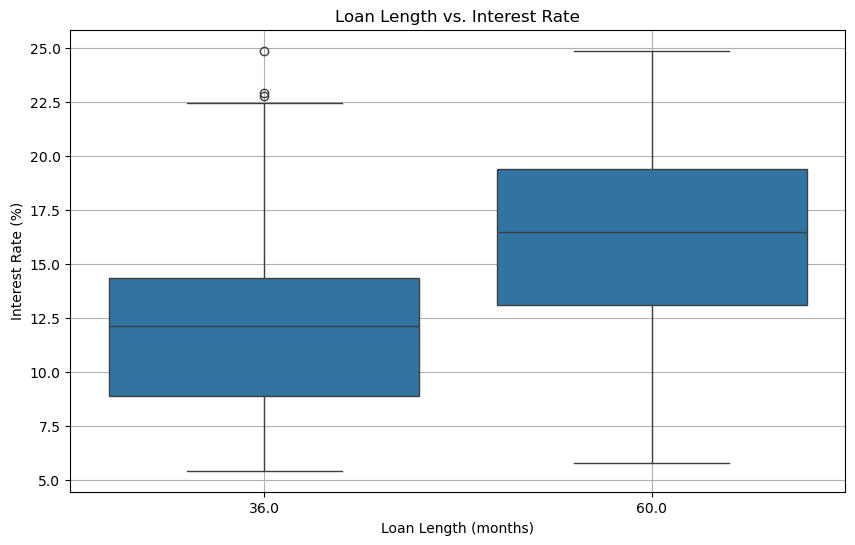

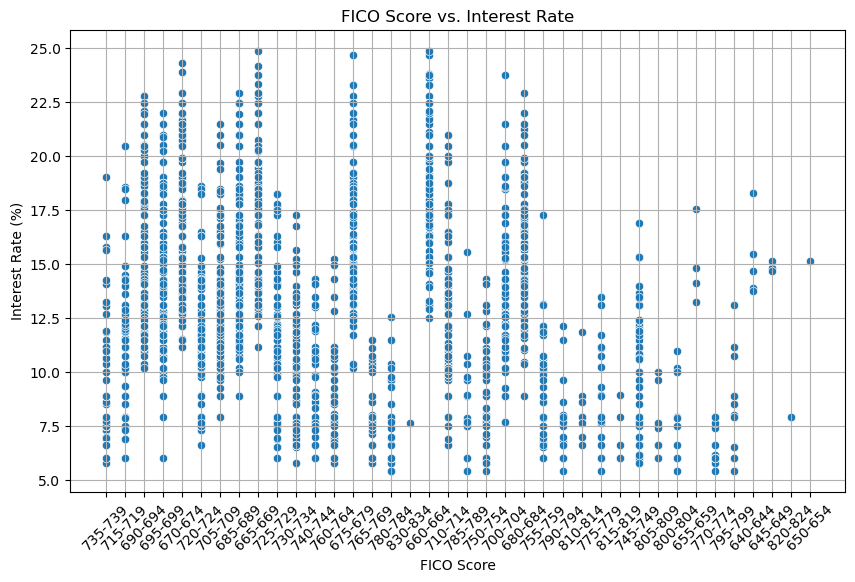

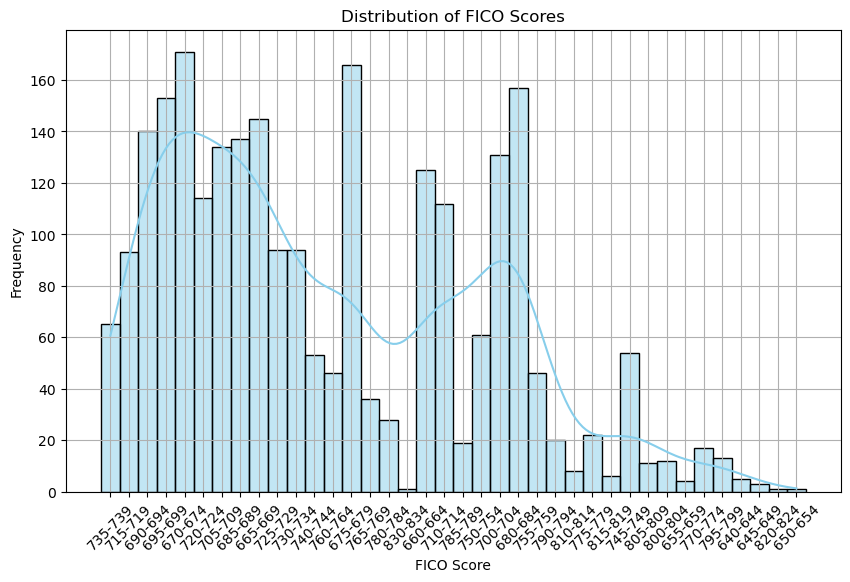

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_length', y='interest_rate', data=bank_data)
plt.title('Loan Length vs. Interest Rate')
plt.xlabel('Loan Length (months)')
plt.ylabel('Interest Rate (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='fico_range', y='interest_rate', data=bank_data)
plt.title('FICO Score vs. Interest Rate')
plt.xticks(rotation=45)
plt.xlabel('FICO Score')
plt.ylabel('Interest Rate (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=bank_data['fico_range'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of FICO Scores')
plt.xticks(rotation=45)
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

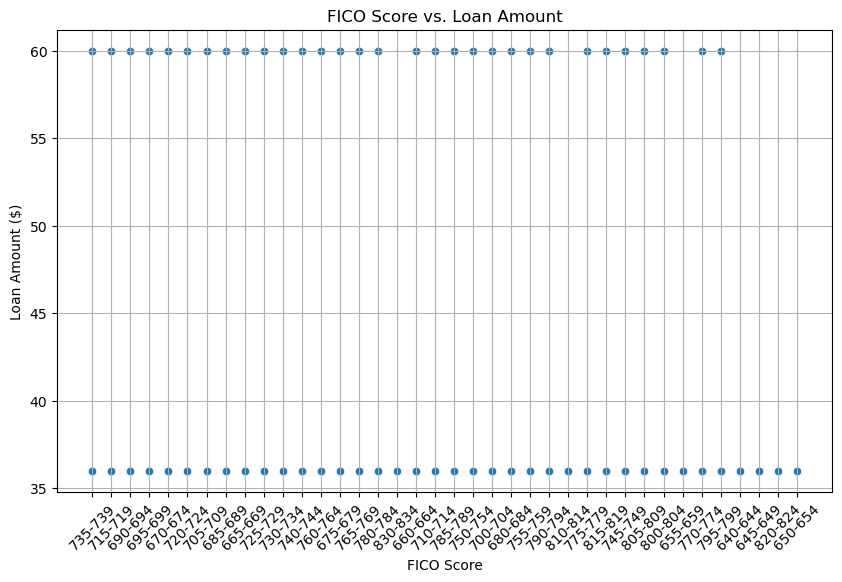

Correlation between FICO Score and Interest Rate: -0.71
Correlation between FICO Score and Loan Amount: 0.01


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fico_range', y='loan_length', data=bank_data)
plt.title('FICO Score vs. Loan Amount')
plt.xlabel('FICO Score')
plt.ylabel('Loan Amount ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Calculate correlation coefficients
correlation_interest_rate = bank_data['fico_mean'].corr(bank_data['interest_rate'])
correlation_loan_amount = bank_data['fico_mean'].corr(bank_data['loan_length'])
print(f'Correlation between FICO Score and Interest Rate: {correlation_interest_rate:.2f}')
print(f'Correlation between FICO Score and Loan Amount: {correlation_loan_amount:.2f}')

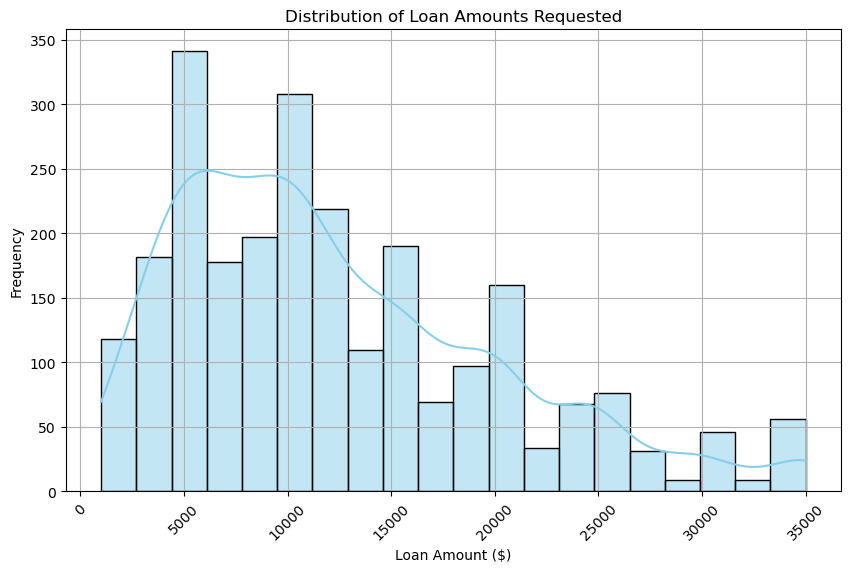

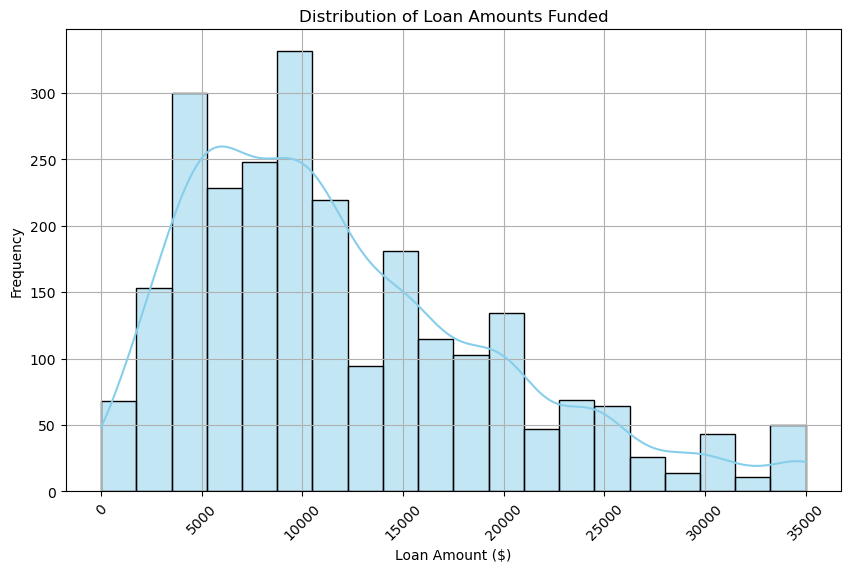

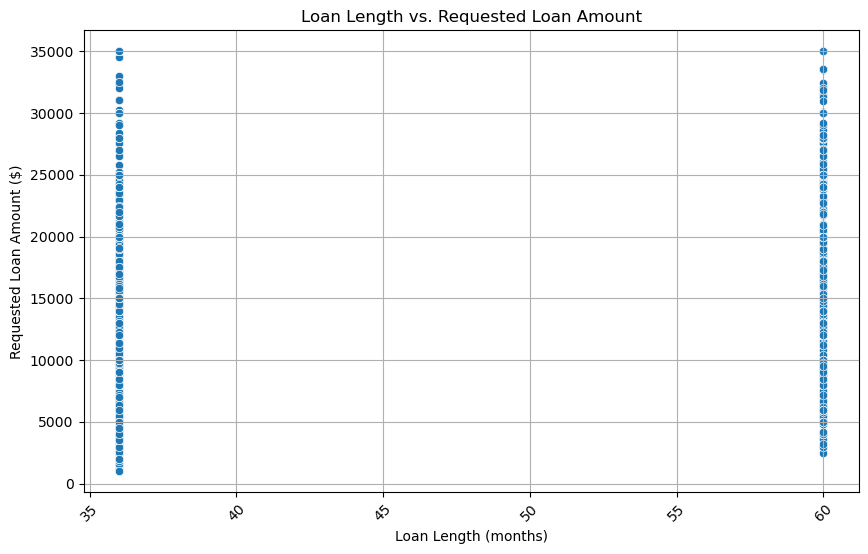

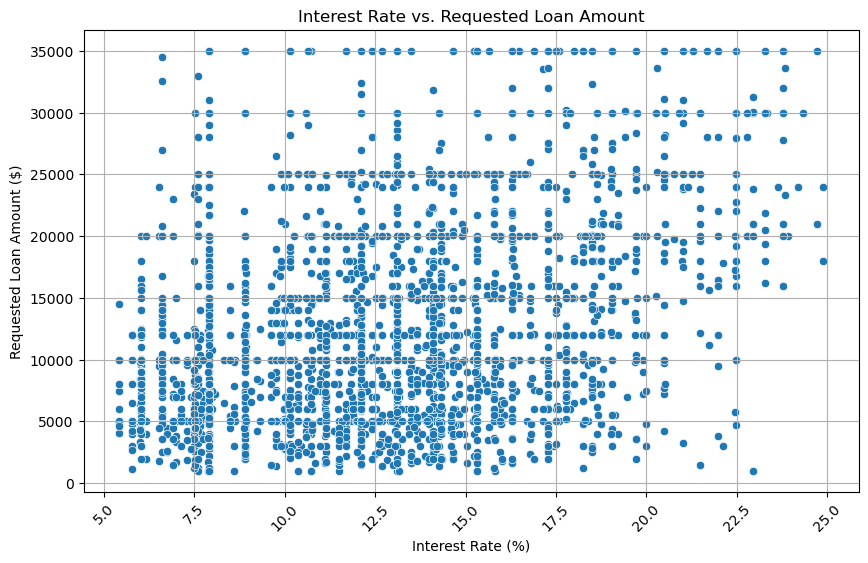

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=bank_data['amount_requested'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Loan Amounts Requested')
plt.xlabel('Loan Amount ($)')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=bank_data['amount_funded_by_investors'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Loan Amounts Funded')
plt.xlabel('Loan Amount ($)')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='loan_length', y='amount_requested', data=bank_data)
plt.title('Loan Length vs. Requested Loan Amount')
plt.xlabel('Loan Length (months)')
plt.ylabel('Requested Loan Amount ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='interest_rate', y='amount_requested', data=bank_data)
plt.title('Interest Rate vs. Requested Loan Amount')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Requested Loan Amount ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

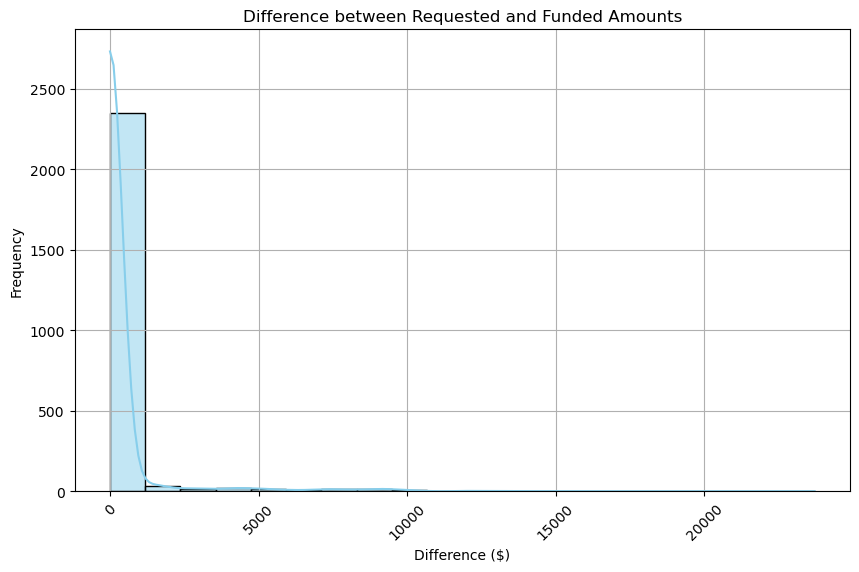

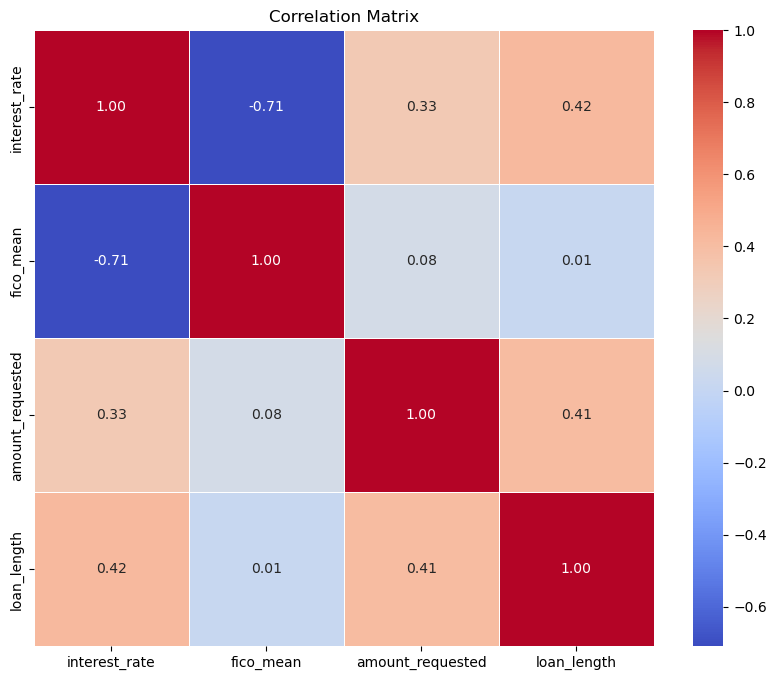

In [ ]:
bank_data['funded_diff'] = bank_data['amount_requested'] - bank_data['amount_funded_by_investors']
plt.figure(figsize=(10, 6))
sns.histplot(data=bank_data['funded_diff'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Difference between Requested and Funded Amounts')
plt.xlabel('Difference ($)')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

correlation_matrix = bank_data[['interest_rate', 'fico_mean', 'amount_requested', 'loan_length']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Define the target variable
target = 'interest_rate'
# Convert annual interest rate to monthly interest rate
bank_data['monthly_interest_rate'] = bank_data['interest_rate'] / 12 / 100
# Calculate total interest
bank_data['total_interest'] = bank_data['monthly_interest_rate'] * bank_data['amount_funded_by_investors'] * bank_data['loan_length']
# Calculate total repayment
bank_data['total_repayment'] = bank_data['amount_funded_by_investors'] + bank_data['total_interest']
# Calculate yearly interest
bank_data['Yearly_Interest'] = bank_data['total_interest'] / (bank_data['loan_length'] / 12)
# Calculate monthly interest
bank_data['monthly_interest'] = bank_data['total_interest'] / bank_data['loan_length']
# Calculate monthly installment
bank_data['monthly_installment'] = bank_data['total_repayment'] / bank_data['loan_length']
bank_data.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_low,fico_high,fico_mean,Principal_Cash_Flow,Effective_Annual_Rate,...,Total_Monthly_Cash_Flow,Monthly_Payment,funded_diff,total_interest,total_repayment,Yearly_Interest,monthly_interest,monthly_installment,tenure_year,monthly_interest_rate
0,8.90,735-739,20000.0,20000.0,36.0,735.0,739.0,737.0,555.56,0.2472,...,692.89,692.89,0.0,5340.0000,25340.0000,1780.0000,148.333333,703.888889,3.0,0.007417
1,12.12,715-719,19200.0,19200.0,36.0,715.0,719.0,717.0,533.33,0.3367,...,712.90,712.90,0.0,6981.1200,26181.1200,2327.0400,193.920000,727.253333,3.0,0.010100
2,21.98,690-694,35000.0,35000.0,60.0,690.0,694.0,692.0,583.33,0.3663,...,797.00,797.00,0.0,38465.0000,73465.0000,7693.0000,641.083333,1224.416667,5.0,0.018317
3,9.99,695-699,10000.0,9975.0,36.0,695.0,699.0,697.0,277.08,0.2775,...,353.97,353.97,25.0,2989.5075,12964.5075,996.5025,83.041875,360.125208,3.0,0.008325
4,11.71,695-699,12000.0,12000.0,36.0,695.0,699.0,697.0,333.33,0.3253,...,441.76,441.76,0.0,4215.6000,16215.6000,1405.2000,117.100000,450.433333,3.0,0.009758


In [ ]:
def estimate_interest_rate(fico_score, loan_amount, loan_length):
    # Define base interest rate based on market conditions
    base_interest_rate = 0.05  # 5% base interest rate
    
    # Define factors affecting interest rate
    fico_factor = fico_score / 850.0  # Normalize FICO score to range [0, 1]
    loan_amount_factor = np.log(loan_amount + 1) / 10.0  # Logarithmic transformation for loan amount
    loan_length_factor = loan_length / 60.0  # Normalize loan length to range [0, 1] (assuming max loan length of 5 years)

    # Calculate total interest rate based on factors
    total_interest_rate = base_interest_rate \
        + fico_factor * 0.02 \
        + loan_amount_factor * 0.03 \
        + loan_length_factor * 0.01 
    
    # Return the estimated interest rate
    return total_interest_rate

# Example usage
fico_score = 735
loan_amount = 20000
loan_length = 36  # Loan length in months (3 years)

estimated_interest_rate = estimate_interest_rate(fico_score, loan_amount, loan_length)
print("Estimated interest rate:", estimated_interest_rate)

Estimated interest rate: 0.10300473030091734


In [ ]:
def calculate_loan_repayment(principal, annual_interest_rate, loan_term_years):
    # Convert annual interest rate to monthly interest rate
    monthly_interest_rate = annual_interest_rate / 12 / 100
    
    # Convert loan term from years to months
    loan_term_months = loan_term_years * 12
    
    # Calculate monthly payment using the formula for fixed-rate mortgage
    monthly_payment = principal * (monthly_interest_rate * (1 + monthly_interest_rate)**loan_term_months) / \
                      ((1 + monthly_interest_rate)**loan_term_months - 1)
    
    # Calculate total amount repaid
    total_repayment = monthly_payment * loan_term_months
    
    # Calculate total interest earned by the bank
    total_interest_earned = total_repayment - principal
    
    return monthly_payment, total_repayment, total_interest_earned

# Example usage
principal_amount = 20000  # Principal loan amount
annual_interest_rate = 8.9  # Annual interest rate (5%)
loan_term_years = 3  # Loan term in years

monthly_payment, total_repayment, total_interest_earned = calculate_loan_repayment(principal_amount, annual_interest_rate, loan_term_years)

print("Monthly Payment:", monthly_payment)
print("Total Repayment:", total_repayment)
print("Total Interest Earned by the Bank:", total_interest_earned)

Monthly Payment: 635.0642363748227
Total Repayment: 22862.31250949362
Total Interest Earned by the Bank: 2862.3125094936186


Accuracy: 0.736


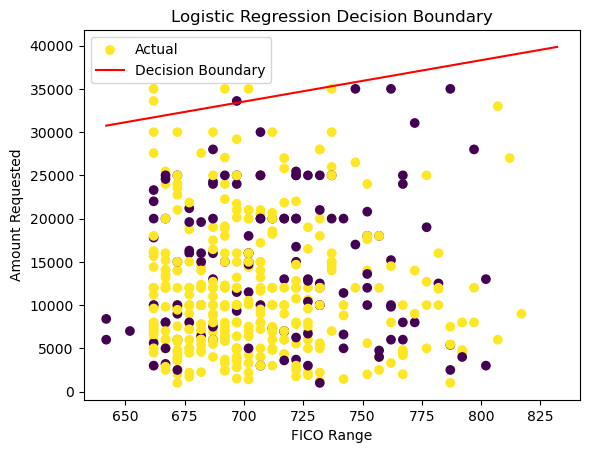

In [ ]:
bank_data['loan_approval'] = (bank_data['amount_funded_by_investors'] >= bank_data['amount_requested']).astype(int)
# Step 2: Feature Selection
X = bank_data[['fico_mean', 'amount_requested']]  # Features
y = bank_data['loan_approval']  # Target variable
# Step 3: Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 4: Model Selection (example: Logistic Regression)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# Step 5: Model Training
model.fit(X_train, y_train)
# Step 6: Model Evaluation
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
import numpy as np
import matplotlib.pyplot as plt
# Plot the data points
plt.scatter(X_test['fico_mean'], X_test['amount_requested'], c=y_test, cmap='viridis', label='Actual')
# Generate evenly spaced values for the FICO score
fico_range_values = np.linspace(X['fico_mean'].min(), X['fico_mean'].max(), 100)
# Calculate the corresponding loan amount using the decision boundary (model coefficients)
boundary = -(model.coef_[0][0] * fico_range_values + model.intercept_[0]) / model.coef_[0][1]
# Plot the decision boundary
plt.plot(fico_range_values, boundary, color='red', label='Decision Boundary')
# Set labels and title
plt.xlabel('FICO Range')
plt.ylabel('Amount Requested')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()

R^2 Score: 0.730071527591912
Mean Squared Error: 4.631258612648733


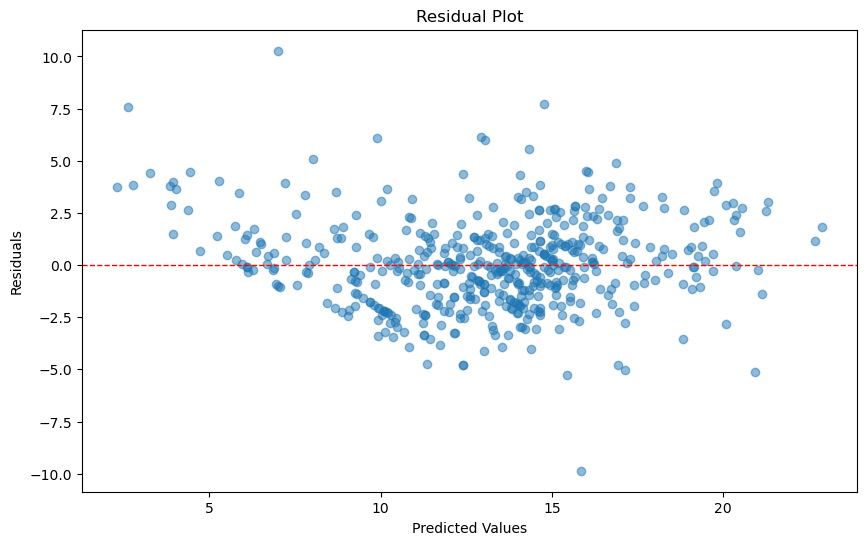

Predicted Interest Rate: 8.721417421732355
Total Interest over Loan Term: 10901.771777165442


/Users/cdmoseley/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [48]:
# Step 1: Prepare Data
X = bank_data[['amount_funded_by_investors', 'loan_length', 'fico_mean']]
y = bank_data['interest_rate']
# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 3: Model Selection and Training
model = LinearRegression()
model.fit(X_train, y_train)
# Step 4: Model Evaluation
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R^2 Score:', r2)
print('Mean Squared Error:', mse)
# Step 5: Residual Analysis
residuals = y_test - y_pred
# Plot the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()
# Step 6: Predict Total Interest
# Assuming loan_amount, loan_years, and credit_score are known
loan_amount = 25000  # Example loan amount
loan_years = 5       # Example loan years
credit_score = 720   # Example credit score
# Predict interest rate
predicted_interest_rate = model.predict([[loan_amount, loan_years, credit_score]])
print('Predicted Interest Rate:', predicted_interest_rate[0])
# Calculate total interest over loan term
total_interest = loan_amount * (predicted_interest_rate[0] / 100) * loan_years
print('Total Interest over Loan Term:', total_interest)